# UTS

## 1. Lakukan analisa klasifikasikan berita dengan extraksi fitur model topik modelling dengan classifier naïve bayes dan SVM data 
https://drive.google.com/file/d/1a776C4mmVbC-84gx_No0is9QDfpWFIme/view?usp=drive_link

Membuat sistem klasifikasi berita berbasis teks, di mana fitur teks diambil dari hasil topik (Topic Modeling - LDA), lalu hasilnya dipakai oleh Naïve Bayes dan SVM untuk memprediksi kategori berita.

### Import Library

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from gensim import corpora, models
from gensim.utils import simple_preprocess
import warnings

warnings.filterwarnings("ignore")

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Raihan
[nltk_data]     Fadillah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Memuat Data

In [3]:
df = pd.read_csv('Berita.csv')

df = df[['judul', 'berita', 'kategori']]
print(df.head())

                                               judul  \
0  Airlangga Harap Kenaikan UMP Tingkatkan Daya B...   
1  PT SIER Beri Penghargaan untuk 50 Tenant Terba...   
2  Prabowo Bakal Bentuk Kementerian Penerimaan Ne...   
3  Sinergi Kemenag & BPJS Ketenagakerjaan Lindung...   
4  Pemerintah Segera Bentuk Satgas PHK Usai Tetap...   

                                              berita kategori  
0  Menteri Koordinator (Menko) Bidang Perekonomia...  Ekonomi  
1  Dalam rangka memeriahkan hari jadi ke-50, PT S...  Ekonomi  
2  Wacana Presiden Prabowo Subianto akan membentu...  Ekonomi  
3  BPJS Ketenagakerjaan dan Kementerian Agama (Ke...  Ekonomi  
4  Pemerintah akan segera membentuk Satuan Tugas ...  Ekonomi  


### Cleaning Text

In [4]:
stop_words = stopwords.words('indonesian')

def clean_text(text):
    text = re.sub(r'\d+', '', str(text))
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = [w for w in text.split() if w not in stop_words]
    return ' '.join(tokens)

df['text'] = (df['judul'] + ' ' + df['berita']).apply(clean_text)

### Tokenisasi untuk Topic Modeling (LDA)

In [5]:
tokenized_texts = [simple_preprocess(text) for text in df['text']]
dictionary = corpora.Dictionary(tokenized_texts)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

### Latih Model LDA

In [6]:
num_topics = 5
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=10
)

for idx, topic in lda_model.print_topics(num_words=5):
    print(f"Topik {idx}: {topic}")


Topik 0: 0.012*"israel" + 0.008*"senjata" + 0.008*"gencatan" + 0.007*"gaza" + 0.007*"orang"
Topik 1: 0.018*"indonesia" + 0.011*"timnas" + 0.011*"piala" + 0.010*"pemain" + 0.007*"gol"
Topik 2: 0.020*"laut" + 0.016*"pagar" + 0.007*"tangerang" + 0.005*"suriah" + 0.004*"kkp"
Topik 3: 0.007*"presiden" + 0.006*"program" + 0.006*"makan" + 0.005*"jakarta" + 0.005*"suara"
Topik 4: 0.010*"rp" + 0.008*"persen" + 0.008*"indonesia" + 0.007*"prabowo" + 0.006*"pemerintah"


### Ekstraksi Fitur Topik

In [7]:
def get_topic_vector(doc_bow):
    topic_dist = lda_model.get_document_topics(doc_bow, minimum_probability=0)
    return [prob for _, prob in topic_dist]

X_topics = np.array([get_topic_vector(bow) for bow in corpus])
y = df['kategori']

### Split Data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_topics, y, test_size=0.2, random_state=42, stratify=y)

### Klasifikasi dengan Naïve Bayes

In [9]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("=== Naïve Bayes ===")
print("Akurasi:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

=== Naïve Bayes ===
Akurasi: 0.7
               precision    recall  f1-score   support

      Ekonomi       0.63      0.76      0.69        75
Internasional       0.60      0.71      0.65        75
     Nasional       0.55      0.35      0.43        75
     Olahraga       1.00      0.99      0.99        75

     accuracy                           0.70       300
    macro avg       0.70      0.70      0.69       300
 weighted avg       0.70      0.70      0.69       300



### Klasifikasi dengan SVM

In [10]:
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("=== SVM ===")
print("Akurasi:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

=== SVM ===
Akurasi: 0.69
               precision    recall  f1-score   support

      Ekonomi       0.64      0.79      0.71        75
Internasional       0.59      0.77      0.67        75
     Nasional       0.55      0.21      0.31        75
     Olahraga       0.93      0.99      0.95        75

     accuracy                           0.69       300
    macro avg       0.68      0.69      0.66       300
 weighted avg       0.68      0.69      0.66       300



### Analisis Hasil

- Naïve Bayes → terbaik untuk kasus ini (akurasi 0.70)

- SVM → performa hampir sama, tetapi sedikit menurun karena overlap antar topik.

- Kategori Olahraga paling mudah diprediksi, sedangkan Nasional paling sulit.

- Model bisa ditingkatkan dengan tuning topik LDA, TF-IDF, dan preprocessing lanjutan.

## 2. Lakukan  analisa clutering dokumen pada data email berikut
https://drive.google.com/file/d/1wyFO8424PDG8sDZ_6mBJvoKfiwbWnDe7/view?usp=drive_link


Melakukan clustering dokumen teks email (tanpa label kelas) menggunakan pendekatan NLP

### Import Library 

In [3]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Raihan
[nltk_data]     Fadillah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load Data

In [7]:
df = pd.read_csv('spam.csv', encoding='latin1')

print(df.head())

df = df[['id', 'Text']]
df.dropna(inplace=True)

   id                                               Text Unnamed: 2  \
0   1  Go until jurong point, crazy.. Available only ...        NaN   
1   2                      Ok lar... Joking wif u oni...        NaN   
2   3  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   4  U dun say so early hor... U c already then say...        NaN   
4   5  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


### Preprocessing Teks

In [8]:
stop_words = stopwords.words('english')

def clean_text(text):
    text = re.sub(r'http\S+|www.\S+', '', str(text))  # hapus URL
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # hanya huruf
    text = text.lower()
    tokens = [word for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['Text'].apply(clean_text)

### Ekstraksi Fitur: TF-IDF

In [9]:
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['clean_text'])

### Tentukan Jumlah Cluster Optimal (Elbow & Silhouette)

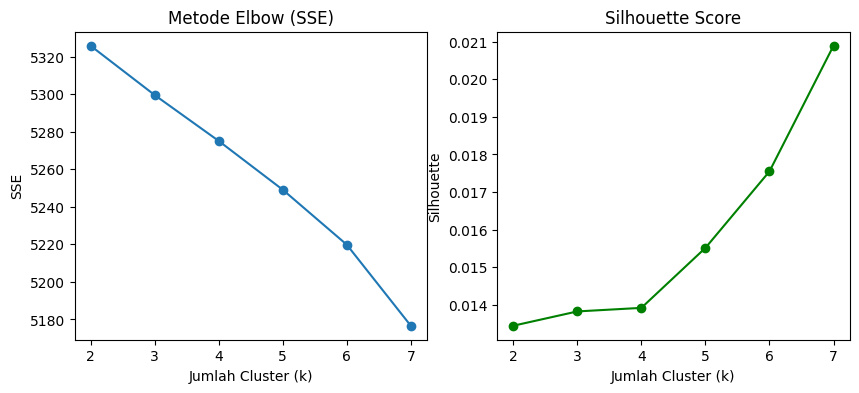

In [10]:
sse = []
silhouette = []
K_range = range(2, 8)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    sse.append(km.inertia_)
    silhouette.append(silhouette_score(X, km.labels_))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K_range, sse, marker='o')
plt.title('Metode Elbow (SSE)')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('SSE')

plt.subplot(1,2,2)
plt.plot(K_range, silhouette, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette')
plt.show()


### Clustering dengan K-Means

In [11]:
k = 2
model = KMeans(n_clusters=k, random_state=42)
labels = model.fit_predict(X)

df['cluster'] = labels

### Analisis Hasil Cluster

In [12]:
print(df['cluster'].value_counts())

# Gabungkan teks berdasarkan cluster
for i in range(k):
    cluster_text = ' '.join(df[df['cluster'] == i]['clean_text'])
    freq_words = pd.Series(cluster_text.split()).value_counts().head(10)
    print(f"\n=== Cluster {i} ===")
    print(freq_words)


cluster
0    5083
1     489
Name: count, dtype: int64

=== Cluster 0 ===
u       1062
im       452
get      373
ur       370
dont     277
go       275
ltgt     269
ok       267
know     242
like     239
Name: count, dtype: int64

=== Cluster 1 ===
call      527
free      104
claim      82
u          81
prize      79
mobile     71
urgent     58
please     56
later      55
ill        53
Name: count, dtype: int64


### Visualisasi 2D Hasil Clustering

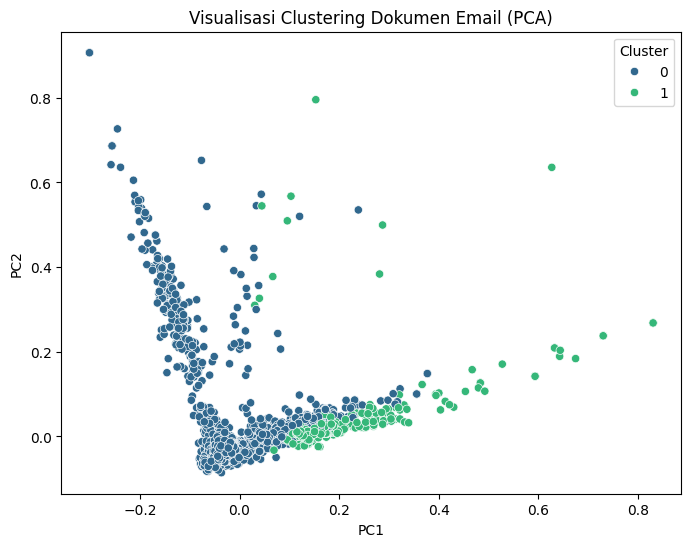

In [13]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette='viridis')
plt.title('Visualisasi Clustering Dokumen Email (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()

### Interpretasi Hasil

- Cluster 0 (Ham) Mayoritas email (91.2%) menggunakan bahasa informal, singkatan (u, im), dan mewakili komunikasi normal sehari-hari.

- Cluster 1 (Spam) Minoritas email (8.8%) menggunakan bahasa yang mendesak (urgent), menawarkan hadiah/klaim (claim, prize), dan merupakan email promosi/penipuan.

- Efektivitas Model Clustering sukses memisahkan data email menjadi dua kategori utama, sangat efektif untuk aplikasi deteksi spam.

- Visualisasi (PCA) PC1 menjadi pembeda utama, memisahkan secara visual kedua kelompok email normal dan spam.